<table><tr>
<td> <img src="images/ProjectPythia_Logo_Final-01-Blue.svg" width=150 alt="Project Pythia Logo"></img> </td>
<td><img src="images/logos/numpy_logo.svg" width=250 alt="NumPy Logo"></img></td>
<td><img src="images/logos/xarray_logo.png" width=250 alt="Xarray Logo"></img></td>
</tr>
<tr>
<td><img src="images/logos/cartopy_logo.png" width=250 alt="Cartopy Logo"></img></td>
<td><img src="images/logos/geocat_logo.svg" width=300 alt="GeoCAT Logo"></img></td>
<td><img src="images/logos/matplotlib_logo.svg" width=300 </tr></table>

# Matplotlib: Consistant Colorbars for Comparisons

---

## Overview
Analyzing data almost always requires comparing datasets, and when done visually, this is a powerful way to communicate changes. However, to do this acurately in color, the colormap used by the datasets must be the same. The colors on each plot must have the same meanings and values assigned to them. This cookbook shows how to:

1. create multiple plots but display only one colorbar
1. use the same colormap for multiple plots
1. choose accessible colormaps and explains best practices when using color

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Opening data sets |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html#overview) | Necessary | [Contour/Filled Contour Plots](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html#contour-and-filled-contour-plots) |
| [Basic Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html#opening-netcdf-data) | Necessary | [Opening netCDF data](https://foundations.projectpythia.org/core/xarray/xarray-intro.html#opening-netcdf-data) |
| [Basic Numpy](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Necessary | |
| [GeoCAT-viz](https://geocat-viz.readthedocs.io/en/latest/) | Helpful | For formatting plots |

- **Time to learn**: 15 minutes

---

## Imports

In [1]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmaps

import geocat.datafiles as gdf
import geocat.viz as gv
%matplotlib inline

/Users/hcraker/miniconda3/envs/colorbar-cookbook/lib/python3.10/site-packages/geocat/viz/cmaps.py:9: DeprecationWarning: geocat.viz.cmaps is deprecated, use cmaps instead
  warnings.warn("geocat.viz.cmaps is deprecated, use cmaps instead",


## Loading in and preprocessing data

The data we are using for this example is from the [GeoCAT-datafiles](https://github.com/NCAR/geocat-datafiles) repository on GitHub. The specific file is `TS.cam3.toga_ENS.1950-2000.nc`, and it contains surafce temeprature data from the first run of the CAM3 T85 TOGA model run. We load the data file in using the xarray default engine.

In [2]:
ds = xr.open_dataset(gdf.get("netcdf_files/TS.cam3.toga_ENS.1950-2000.nc"),)
ds

/Users/hcraker/miniconda3/envs/colorbar-cookbook/lib/python3.10/site-packages/xarray/backends/plugins.py:98: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entrypoints = entry_points().get("xarray.backends", ())


<xarray.Dataset>
Dimensions:  (time: 612, lat: 128, lon: 256)
Coordinates:
  * time     (time) object 1950-02-01 00:00:00 ... 2001-01-01 00:00:00
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    TS       (time, lat, lon) float32 ...
Attributes:
    title:          CAM3 T85 TOGA Run #1 (eul128x256_d63vamip_trpsst_01), run...
    source_mss:     /BRUCEB/csm/eul128x256_d63vamip_trpsst_01/atm/hist/
    source:         /home/asphilli/DSets/t85toga.vartscreate.ncl
    creation_date:  Mon Jan 31 14:34:17 MST 2005
    history:        Fri Aug  5 13:31:09 2005: ncea CAM3TOGA01/TS.cam3.toga_01...

The file has data from different timesteps of the model. Say we want to plot temperature data from two different timesteps and compare them visually. To see the biggest change, let's choose a timestep from February and one from August in the same year. We also need to select the variable of interest which is `TS` for surface temperature.

To create the colorbar, we'll need to know what the minimum and maximum temperatures are. We find those here as well.

In [3]:
first_step = ds.isel(time=0).TS
last_step = ds.isel(time=6).TS
min_val = np.floor(min([first_step.min(), last_step.min()]).values)
max_val = np.ceil(max([first_step.max(), last_step.max()]).values)

## Making the Plot
Due to Jupyter Notebook limitations, the entire plot must be made in the same block. These are the general steps:

### Create the figure

We are using `matplotlib` and `cartopy` to make two plots on the same figure. We need to create the figure and specify our map projection before we can create the two subplots.

### Format and populate subplots

Once that's done, we need to format and populate the subplots. The function `create_subplot` below ensures that both sets of axes are created with the same specifications. *Most importantly, it makes sure that both plots are drawn with the same `levels` keyword for `contourf`.* This keyword is what specifies how the colors are assigned to values. As long as `levels` is the same between contour plots, the images will be useful for making accurate comparisions.

### Making the colorbar

`contourf` returns a `QuadContourSet` object. This holds the information about how colors are assigned to values and where the contours are drawn. Since both plots were made with the same parameters, the returned objects are identical in regards to color assignments. Either can be passed into `plt.colorbar`.

To make the colorbar appear below both plots, the `ax` parameter must be set to the lower axes `ax2`. Then `orientation` is set to `'horizontal'`. Additional [keyword arguments](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html#matplotlib.pyplot.colorbar) can be passed in to `plt.colorbar` to further customize its appearance.

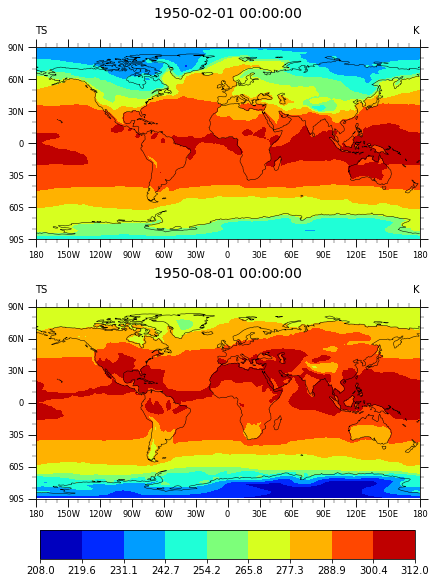

In [6]:
# Helper function to format and populate subplots
def create_plot(ax, data, cmap):
    # Use geocat.viz.util convenience function to set axes tick values
    gv.set_axes_limits_and_ticks(ax=ax,
                                 xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 13),
                                 yticks=np.linspace(-90, 90, 7))

    # Use geocat.viz.util convenience function to make plots look like NCL
    # plots by using latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)

    # Remove the degree symbol from tick labels
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))

    # Use geocat.viz.util convenience function to add minor and major ticks
    gv.add_major_minor_ticks(ax)

    # Draw coastlines
    ax.coastlines(linewidth=0.5)

    # Use geocat.viz.util convenience function to set titles
    gv.set_titles_and_labels(ax,
                             maintitle=data.time.values,
                             lefttitle='TS',
                             righttitle='K',
                             maintitlefontsize=12,
                             lefttitlefontsize=10,
                             righttitlefontsize=10)
    
    return ax.contourf(data['lon'], data['lat'], data.data, cmap=cmap, levels=np.linspace(min_val, max_val, 10))

# Creating the figure and subplots
fig = plt.figure(figsize=(24, 8), constrained_layout=True)
proj = ccrs.PlateCarree()
ax1 = fig.add_subplot(2,1,1, projection=proj)
ax2 = fig.add_subplot(2,1,2, projection=proj)

# Plotting data
mappable = create_plot(ax1, first_step, 'jet')
mappable = create_plot(ax2, last_step, 'jet')

# Making colorbar
cbar = fig.colorbar(mappable, ax=ax2, orientation='horizontal', aspect=13)

## Best Practices when Using Color
Color is a useful tool for communicating information. However, there are important factors to consider when choosing color palettes that may not be obvious at first.

### Printing in Black and White
If your plot is printed in black and white, there can be issues telling the colors apart and interpreting the plot. This is because the colors are reduced to thier brightness. Colormaps have a variety of hues and levels of saturation to communicate information, but not all of them are designed to have linear changes in brightness for black and white printing. Below is an example of how the rainbow colormap we used before is hard to interpret in black and white.

<table><tr><td>
<img src="images/jet.png" width=100% alt="Two world maps with temperature contours. The contours are drawn with a rainbow color palette."></img></td>
<td>
    
<img src="images/jet_bw.png" width=100% alt="Two world maps with temperature contours. The image has been converted to grayscale."></img></td></tr></table>

### Choosing Accessible Color Palette
Colorblindness affects approximately 1 in 12 men and 1 in 200 women [[1]](https://www.colourblindawareness.org/colour-blindness/). To make sceintific information accessible to everyone, how different kinds of colorblindness affect the interpretation of color schemes must be taken into account.

Below is an approximation of how someone with deuteranomaly colorblindness would see the plot we created. This kind of color deficiency can be described as "green weakness" since the green receptors in the eyes exist but have differences in how sensitive they are to green light. This is the most common kind of colorblindness, but there are many other types [[2]](https://www.color-blindness.com/types-of-color-blindness/). 

Note that some of the colors are now hard to distinguish and the plot is harder to interpret [[3]](https://www.color-blindness.com/coblis-color-blindness-simulator/).
<table><tr><td>
<img src="images/jet.png" width=100% alt="Two world maps with temperature contours. The contours are drawn with a rainbow color palette."></img></td>
<td>
    
<img src="images/jet_deuteranomaly.png" width=100% alt="Two world maps with temperature contours. The image has been modified to simulate deuteranomaly color deficiency."></img></td></tr></table>

Recommended colormaps for sequential data are `viridis`, `plasma`, `inferno`, `magma`, and `cividis`. These colormaps increase linearly in brightness, thus the actual hue of the colors is not the only way to distinguish them. Below is an example of the `plasma` colormap and how it looks in simulated deuteranomaly and in grayscale. This colormap is still easily interpretable with deuteranomaly and grayscale printing.

<table><tr><td>
<img src="images/plasma.png" width=100% alt="Two world maps with temperature contours. The contours are drawn with a rainbow color palette."></img></td>
<td><img src="images/plasma_deuteranomaly.png" width=100% alt="Two world maps with temperature contours. The image has been modified to simulate deuteranomaly color deficiency."></img></td><td><img src="images/plasma_bw.png" width=100% alt="Two world maps with temperature contours. The image has been converted to grayscale."></img></td>
</tr></table>

### Alternative Color Palettes
Matplotlib has an [entire lesson](https://matplotlib.org/stable/tutorials/colors/colormaps.html) explaining the different classes of colormaps and the appropriate times to use them. It is a more in depth resource for using color than this cookbook and is highly recommended if you want more information on this topic.

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!


Visualization & Analysis Systems Technologies. (2020). Geoscience Community Analysis Toolkit: GeoCAT-datafiles [Software]. Boulder, CO: UCAR/NCAR - Computational and Informational System Lab. [doi:10.5281/zenodo.6684782](doi:10.5281/zenodo.6684782).